In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json   ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c speaker-recognition-dim0494
!unzip /content/speaker-recognition-dim0494.zip

In [2]:
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import librosa
import os
import torchaudio
from torchaudio.transforms import MelSpectrogram
import numpy as np
from torch import nn
from torchsummary import summary

In [16]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
device

'cuda'

In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce GT 1030'

In [6]:
torch.cuda.get_device_properties(torch.device('cuda:0'))

_CudaDeviceProperties(name='NVIDIA GeForce GT 1030', major=6, minor=1, total_memory=2047MB, multi_processor_count=3)

# 1. Data pre-processing

In [10]:
data = pd.read_csv('train.csv')

In [93]:
data = pd.read_csv('train.csv')

frames =[torchaudio.info(i).num_frames for i in data.iloc[:,1]]
print(f'Average num frames {sum(frames)/len(data)}')

Average num frames 137067.3886319846


1.1 Custom dataset

In [13]:
class CustomAudioDataset(Dataset):
    def __init__(self, annotations_file, device, num_samples, test = False, transform=None, target_transform=None,):
        self.audio_labels = pd.read_csv(annotations_file)
        self.device = device
        self.transform = transform.to(self.device)
        self.target_transform = target_transform
        self.num_samples = num_samples
        self.test = test
    def __len__(self):
        return len(self.audio_labels)

    def _cut(self,audio):
      if audio.shape[1] > self.num_samples:
        audio =  audio[:,:self.num_samples]
      return audio

    def _pad(self,audio):
      if audio.shape[1] < self.num_samples:
        n_miss_pad = self.num_samples - audio.shape[1]
        padding = (0, n_miss_pad)
        audio = torch.nn.functional.pad(audio, padding)
      return audio

    def __getitem__(self, idx):
        
        audio_path = self.audio_labels.iloc[idx, 1]
        audio, _ = torchaudio.load(audio_path, normalize=True)
        audio = audio.to(self.device)
        audio = self._cut(audio)
        audio = self._pad(audio)
        if self.test == False:
          label = self.audio_labels.iloc[idx, 3]
        if self.test == True:
          label = 0

        if self.transform:
            audio = self.transform(audio)
        if self.target_transform:
            label = self.target_transform(label)

        return audio, label

## 1.2 Transform data (MelSpectrogram) 

In [14]:
SAMPLE_RATE = 24000
N_FFT = 1024
HOP_LENGTH = 512

N_MELS = 128
transform = MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft= N_FFT,
    n_mels=N_MELS,
    hop_length=HOP_LENGTH
)

1.3 Creation and split dataset

In [18]:
training_data = CustomAudioDataset(
  annotations_file= 'train.csv',
  num_samples = 137000,
  transform=transform,
  device=device,
  
)
test_data = CustomAudioDataset(
  annotations_file= 'test.csv',
  num_samples = 137000,
  transform=transform,
  device=device,
  test = True
  
)
training_data[0][0].shape

torch.Size([1, 128, 268])

In [ ]:
for i in range(10380):
   training_data[i][0].shape == (1, 128, 586)

In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=32,  shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [20]:
train_features, train_labels = next(iter(train_dataloader))

In [21]:
train_labels[0]

tensor(35)

In [22]:
test_features, test_labels = next(iter(test_dataloader))
test_labels[0]

tensor(0)

In [23]:
train_features.shape

torch.Size([32, 1, 128, 268])

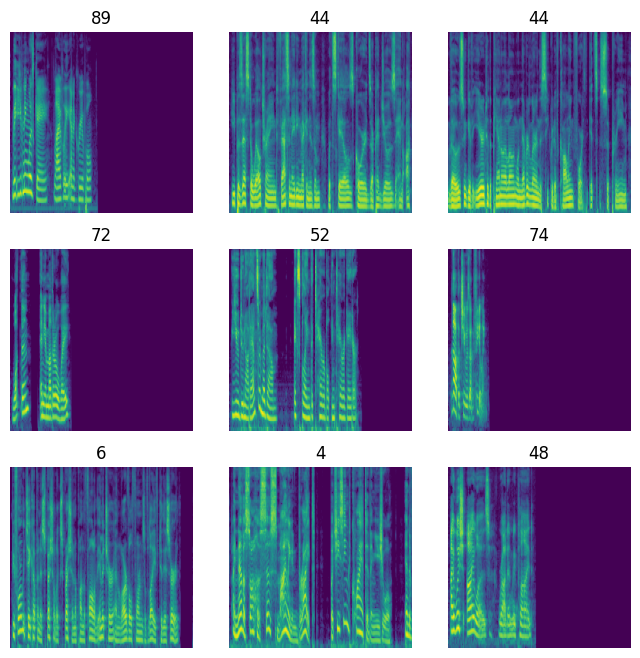

In [24]:
figure = plt.figure(figsize=(8, 8))
figure
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    spec, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(librosa.power_to_db(spec[0].cpu()), origin="lower", aspect="auto")
plt.show()


# 2. Model

In [25]:
from torch.nn.functional import softmax
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.conv_1 = nn.Sequential(
        nn.Conv2d(1,64,(7,7), stride = 1, padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(64)
        )
    self.conv_2 = nn.Sequential(
        nn.Conv2d(64,128,(5,5), stride = 1, padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(128),
        nn.Dropout2d(p=0.2)
    )
    self.conv_3 = nn.Sequential(
        nn.Conv2d(128,128,(2,2), stride = 1, padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(128) 
    )

    
    self.dense_layer = nn.Sequential(
        nn.Linear(128*6*15, 128), 
        nn.Linear(128,90),
        )
    self.Softmax = nn.Softmax(dim=1)

  def forward(self,x):
   
   x = self.conv_1(x)
   x = self.conv_2(x)
   x = self.conv_3(x)
   x = self.conv_3(x)

   x = self.flatten(x)  
   x = self.dense_layer(x)
   pred = self.Softmax(x)

   return x

In [26]:
conv1 = nn.Conv2d(1,64,(3,7), stride = 1, padding='valid').to(device)
conv2 = nn.Conv2d(64,128,(3,3), stride = 1, padding='valid').to(device)
conv3 = nn.Conv2d(128,128,(2,2), stride = 1, padding='valid').to(device)
#conv4 = nn.Conv2d(128,128,(26,140), stride = 1, padding='valid').to(device)


x = train_features[0].to(device)
maxpool = nn.MaxPool2d(kernel_size=2)
x2 = conv1(x)
x2 = maxpool(x)
x = conv1(x)

x = maxpool(x)

x = conv2(x)
maxpool2 = nn.MaxPool2d(kernel_size=2)
x = maxpool2(x)

x = conv3(x)
x = maxpool2(x)
x = conv3(x)
x = maxpool2(x)
#x = conv4(x)
x.shape

torch.Size([128, 6, 15])

In [28]:
cnn = CNN()
summary(cnn.to(device), train_features.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 61, 131]         --
|    └─Conv2d: 2-1                       [-1, 64, 122, 262]        3,200
|    └─ReLU: 2-2                         [-1, 64, 122, 262]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 61, 131]         --
|    └─BatchNorm2d: 2-4                  [-1, 64, 61, 131]         128
├─Sequential: 1-2                        [-1, 128, 28, 63]         --
|    └─Conv2d: 2-5                       [-1, 128, 57, 127]        204,928
|    └─ReLU: 2-6                         [-1, 128, 57, 127]        --
|    └─MaxPool2d: 2-7                    [-1, 128, 28, 63]         --
|    └─BatchNorm2d: 2-8                  [-1, 128, 28, 63]         256
|    └─Dropout2d: 2-9                    [-1, 128, 28, 63]         --
├─Sequential: 1-3                        [-1, 128, 13, 31]         --
|    └─Conv2d: 2-10                      [-1, 128, 27, 62]         65,664
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 61, 131]         --
|    └─Conv2d: 2-1                       [-1, 64, 122, 262]        3,200
|    └─ReLU: 2-2                         [-1, 64, 122, 262]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 61, 131]         --
|    └─BatchNorm2d: 2-4                  [-1, 64, 61, 131]         128
├─Sequential: 1-2                        [-1, 128, 28, 63]         --
|    └─Conv2d: 2-5                       [-1, 128, 57, 127]        204,928
|    └─ReLU: 2-6                         [-1, 128, 57, 127]        --
|    └─MaxPool2d: 2-7                    [-1, 128, 28, 63]         --
|    └─BatchNorm2d: 2-8                  [-1, 128, 28, 63]         256
|    └─Dropout2d: 2-9                    [-1, 128, 28, 63]         --
├─Sequential: 1-3                        [-1, 128, 13, 31]         --
|    └─Conv2d: 2-10                      [-1, 128, 27, 62]         65,664
|

In [32]:
import datetime



#Train

In [29]:
from torch import optim
loss_func = nn.CrossEntropyLoss()   

In [30]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1,  patience=5)

In [36]:
def train(dataloader, model, loss_fn, optimizer,epoch):
    size = len(dataloader.dataset)
    model.train()
    correct =0
    losses =[]
    accs =[]
    for batch, (X, y) in enumerate(dataloader,start=1):
        X, y = X.to(device), y.to(device)
      

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        losses.append(loss.item())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        accs.append(correct/batch * len(X))

        if batch % 100 == 0 or batch == 1:
          loss, current = loss.item(), batch * len(X)


          acc_per_batch = correct/current

          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d} Accuracy: { acc_per_batch }]")
          

    print(f'Accuracy :{correct/len(dataloader.dataset)}')
    torch.save(model, f'./model_saved{epoch}.pth')
    return losses,accs, model, correct 

In [37]:
accs =[]
losses = []
EPOCHS =20
for i in range(EPOCHS):
  print(f'Epoch{i+1}')
  history = train(train_dataloader,cnn,loss_func,optimizer,i)
  avg_loss = sum(history[0])/len(history[0])
  print(f'avg_loss: {avg_loss}')
  scheduler.step(avg_loss)
  accs.append(history[3]/len(train_dataloader.dataset))
  losses.append(avg_loss)
 

Epoch1
loss: 1.457008  [   32/10380 Accuracy: 0.53125]
loss: 0.674632  [ 3200/10380 Accuracy: 0.705]
loss: 0.801450  [ 6400/10380 Accuracy: 0.74296875]
loss: 0.290101  [ 9600/10380 Accuracy: 0.7694791666666667]
Accuracy :0.7752408477842004
avg_loss: 0.8085616894983328
Epoch2
loss: 0.726400  [   32/10380 Accuracy: 0.84375]
loss: 0.395106  [ 3200/10380 Accuracy: 0.8665625]
loss: 0.397424  [ 6400/10380 Accuracy: 0.88171875]
loss: 0.202868  [ 9600/10380 Accuracy: 0.8889583333333333]
Accuracy :0.8917148362235068
avg_loss: 0.36650279938028407
Epoch3
loss: 0.575168  [   32/10380 Accuracy: 0.84375]
loss: 0.110723  [ 3200/10380 Accuracy: 0.9271875]
loss: 0.288775  [ 6400/10380 Accuracy: 0.93421875]
loss: 0.033428  [ 9600/10380 Accuracy: 0.9379166666666666]
Accuracy :0.9392100192678228
avg_loss: 0.2061103623217115
Epoch4
loss: 0.103262  [   32/10380 Accuracy: 0.96875]
loss: 0.139127  [ 3200/10380 Accuracy: 0.9578125]
loss: 0.200301  [ 6400/10380 Accuracy: 0.95546875]
loss: 0.085296  [ 9600/10380

In [ ]:
losses

In [ ]:
accs

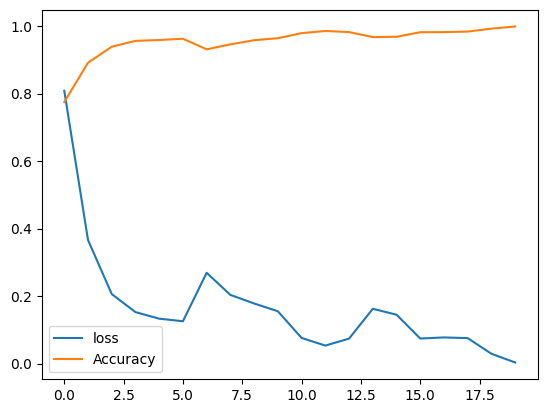

In [45]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(losses, color='tab:blue',label = 'loss')
ax.plot( accs, color='tab:orange',label ='Accuracy')
ax.legend()

plt.show()

In [38]:
y_pred = history[2](train_features)[0]
y_pred.argmax()

tensor(35, device='cuda:0')

In [46]:
model19 = CNN()
model19 = torch.load('./model_saved19.pth')
model19.eval()

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (conv_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense_layer): Sequential(
  

In [49]:
model =history[2]

In [50]:
test_dataloader = DataLoader(test_data,shuffle=False)

In [51]:
test_features, test_labels = next(iter(test_dataloader))
test_features.shape


torch.Size([1, 1, 128, 268])

In [53]:
import csv
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with open('./submission.csv', 'w') as csvfile:
      with torch.no_grad():
          for X, y in dataloader:
              X  = X.to(device)
              pred = model(X)
              csvfile.write(f'{pred.argmax().item()}\n')
              print(pred.argmax().item())

In [68]:


def test_model(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    labels =[]
    predicts =[]
    with torch.no_grad():
        for X, y in dataloader:
            X  = X.to(device)
            pred = model(X)
            labels.extend(y)
            predicts.extend(pred.argmax(1))
    return labels, predicts

In [69]:
labels, predicts = test_model(train_dataloader, model19)

In [85]:
labels = [i.data for i in labels]
predicts = [i for i in predicts]
predicts

[array(35, dtype=int64),
 array(31, dtype=int64),
 array(79, dtype=int64),
 array(69, dtype=int64),
 array(34, dtype=int64),
 array(51, dtype=int64),
 array(50, dtype=int64),
 array(7, dtype=int64),
 array(24, dtype=int64),
 array(36, dtype=int64),
 array(58, dtype=int64),
 array(79, dtype=int64),
 array(4, dtype=int64),
 array(0, dtype=int64),
 array(34, dtype=int64),
 array(15, dtype=int64),
 array(69, dtype=int64),
 array(56, dtype=int64),
 array(56, dtype=int64),
 array(30, dtype=int64),
 array(43, dtype=int64),
 array(75, dtype=int64),
 array(88, dtype=int64),
 array(48, dtype=int64),
 array(47, dtype=int64),
 array(30, dtype=int64),
 array(51, dtype=int64),
 array(37, dtype=int64),
 array(75, dtype=int64),
 array(28, dtype=int64),
 array(3, dtype=int64),
 array(61, dtype=int64),
 array(15, dtype=int64),
 array(50, dtype=int64),
 array(7, dtype=int64),
 array(86, dtype=int64),
 array(4, dtype=int64),
 array(70, dtype=int64),
 array(79, dtype=int64),
 array(58, dtype=int64),
 array

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm =confusion_matrix(labels,predicts )


<AxesSubplot:>

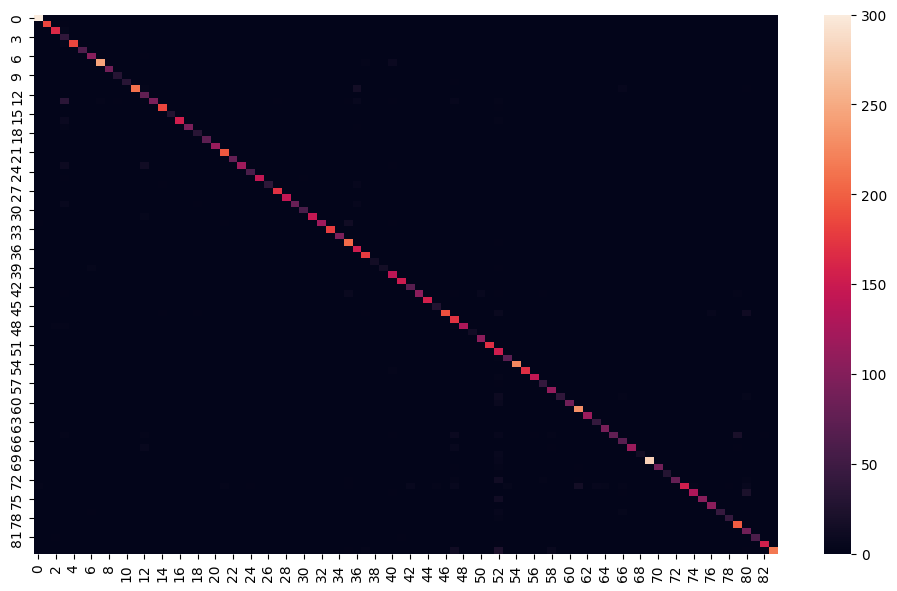

In [92]:
plt.figure(figsize = (12,7))
sn.heatmap(cm)

In [54]:
test(test_dataloader,model19)

48
14
60
78
3
0
6
23
33
44
37
24
89
51
1
66
32
8
58
11
86
56
71
61
71
10
21
51
37
69
44
7
40
37
34
56
75
35
57
65
6
43
43
50
40
54
37
88
43
3
58
37
7
49
30
56
25
38
66
74
85
2
13
56
85
6
52
56
35
3
56
34
89
63
31
84
7
17
14
67
12
44
82
54
38
79
63
84
23
19
79
19
24
23
58
89
79
74
66
79
82
43
45
10
3
50
50
51
70
66
6
51
12
60
48
66
12
2
88
89
51
61
71
58
58
85
61
9
48
26
88
2
58
45
2
74
25
61
55
55
51
45
50
85
69
4
10
51
24
35
49
38
48
28
66
56
50
76
30
72
50
48
51
60
83
26
3
80
20
33
44
7
1
75
44
83
81
52
44
70
63
40
13
54
44
86
17
61
7
79
79
3
86
58
58
37
79
43
85
85
48
58
1
60
56
43
81
44
79
48
14
1
5
29
74
30
51
14
21
74
33
43
8
58
60
88
63
0
32
47
71
0
87
35
38
81
0
86
78
25
51
40
63
0
4
34
70
32
51
74
85
82
85
4
40
8
38
79
66
57
66
43
78
67
44
21
24
23
2
9
0
37
63
14
53
86
17
31
37
89
38
45
29
88
56
6
57
51
56
22
36
63
54
37
63
12
1
23
7
88
45
1
56
55
0
25
14
37
13
74
68
79
68
78
87
13
56
51
14
82
22
37
40
70
1
40
35
60
80
6
75
57
82
85
82
40
55
20
54
6
61
51
66
0
37
85
55
38
19
2

In [56]:
df1 = pd.read_csv('./sample_submission.csv')
df1

,id,speaker
0,3138,83
1,1436,33
2,1787,86
3,12323,19
4,7236,45
...,...,...
2591,1466,51
2592,4413,30
2593,3182,37
2594,8562,88


In [57]:
df2 = pd.read_csv('./submission.csv',header=None)
df2 =df2.iloc[:,0]
df2

0       48
1       14
2       60
3       78
4        3
        ..
2591    80
2592     4
2593    21
2594    43
2595    82
Name: 0, Length: 2596, dtype: int64

In [58]:
df1['speaker'] = df2

In [60]:
df1.to_csv('./submission1.csv', index=False)

In [61]:
!kaggle competitions submit -c speaker-recognition-dim0494 -f ./submission1.csv -m "model1"

'kaggle' n�o � reconhecido como um comando interno


ou externo, um programa oper�vel ou um arquivo em lotes.
